# Experiments With GNG Networks
## Artifical Dataset - Circles

Using this notebook https://github.com/itdxer/neupy/blob/master/notebooks/growing-neural-gas/Growing%20Neural%20Gas%20animated.ipynb as a reference, it's possible to use this artificial dataset (sklearn -> make_moons) to train a GNG and show the process of the neurons being organized arround the dataset exemples as an animation in this notebook.

## Imports and Dependencies

In [1]:
from sklearn.datasets import make_moons
import itertools
import numpy as np
import matplotlib.pyplot as plt
from neupy import algorithms
import matplotlib.animation as animation
from tqdm import tqdm_notebook as tqdm
from IPython.display import HTML
from IPython.display import Image

/home/victorreno/anaconda3/envs/neural_networks/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/victorreno/anaconda3/envs/neural_networks/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/victorreno/anaconda3/envs/neural_networks/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/v

## Functions

In [2]:
# Model building

## Create the model reference using the choosen parameters
def create_model(
        input_dim, n_start_nodes=2, shuffle_data=True, verbose=True, step=0.2, neighbour_step=0.05, max_edge_age=100,
        max_nodes=1000, _lambda=1000, alpha=0.5, beta=0.995, min_distance_for_update=0
    ):
    return algorithms.GrowingNeuralGas(
        n_inputs=input_dim,
        n_start_nodes=n_start_nodes,

        shuffle_data=shuffle_data,
        verbose=verbose,

        step=step,
        neighbour_step=neighbour_step,

        max_edge_age=max_edge_age,
        max_nodes=max_nodes,

        n_iter_before_neuron_added=_lambda,
        after_split_error_decay_rate=alpha,
        error_decay_rate=beta,
        min_distance_for_update=min_distance_for_update,
    )

## Create multiple models based of a list of parameters (dicts)
## Returns a list of dicts containing the parameters and the model reference
def create_bundle_of_models(model_parameters):
    return [
        {**{"model": create_model(**model_parameter)}, **model_parameter}
        for model_parameter in model_parameters
    ]

## Creates all of the possible combinations of parameters between two lists
def create_permutations(list_of_data_1, list_of_data_2, list_of_data_3):
    return list(itertools.product(list_of_data_1, list_of_data_2, list_of_data_3))

## Creates a list of dicts containing the parameters desired, using the permutation function
def create_test_parameters(list1, list2, list3):
    return [
        {"max_edge_age": parameter[0], "_lambda": parameter[1], "max_nodes": parameter[2], "verbose": False}
        for parameter in create_permutations(list1, list2, list3)
    ]

## Artificial Moons Dataset

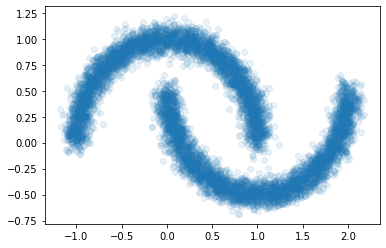

In [9]:
## Use the make_moons function an plot the generated dataset as a scatter plot
## A noise of 0.07 to scatter some stray dots arround the moons, making the training a bit harder
input_data, _ = make_moons(8000, noise=0.07)
plt.scatter(*input_data.T, alpha=0.1)

## Model parameters and building

In [10]:
max_edge_age_list = [1, 100, 200]
lambda_list = [100, 2000]
max_nodes_list = [100, 2000]

# Number of features, in this case, 4
input_dim = input_data.shape[1]

models = create_bundle_of_models(
    [
        {**parameters, **{"input_dim": input_dim}}
        for parameters in create_test_parameters(max_edge_age_list, lambda_list, max_nodes_list)
    ]
)
models

[{'model': GrowingNeuralGas(verbose=False, step=0.2, show_epoch=1, shuffle_data=True, signals=None, n_inputs=2, n_start_nodes=2, neighbour_step=0.05, max_edge_age=1, max_nodes=100, n_iter_before_neuron_added=100, after_split_error_decay_rate=0.5, error_decay_rate=0.995, min_distance_for_update=0),
  'max_edge_age': 1,
  '_lambda': 100,
  'max_nodes': 100,
  'verbose': False,
  'input_dim': 2},
 {'model': GrowingNeuralGas(verbose=False, step=0.2, show_epoch=1, shuffle_data=True, signals=None, n_inputs=2, n_start_nodes=2, neighbour_step=0.05, max_edge_age=1, max_nodes=2000, n_iter_before_neuron_added=100, after_split_error_decay_rate=0.5, error_decay_rate=0.995, min_distance_for_update=0),
  'max_edge_age': 1,
  '_lambda': 100,
  'max_nodes': 2000,
  'verbose': False,
  'input_dim': 2},
 {'model': GrowingNeuralGas(verbose=False, step=0.2, show_epoch=1, shuffle_data=True, signals=None, n_inputs=2, n_start_nodes=2, neighbour_step=0.05, max_edge_age=1, max_nodes=100, n_iter_before_neuron_ad

## Training

In [11]:
def animate_training(i, data, model):
    for line in animate_training.prev_lines:
        line.remove()
    
    # Training will slow down overtime and we increase number
    # of data samples for training
    n = int(0.5 * model.n_iter_before_neuron_added * (1 + i // 100))
    
    sampled_data_ids = np.random.choice(len(data), n)
    sampled_data = data[sampled_data_ids, :]
    model.train(sampled_data, epochs=1)
    
    lines = []
    for node_1, node_2 in model.graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')

        plt.setp(line, linewidth=1, color='black')
        
        lines.append(line)
        lines.append(plt.scatter(*weights.T, color='black', s=10))
    
    animate_training.prev_lines = lines
    return lines

def train_gng(model, input_data, file_name):
    # training
    animate_training.prev_lines = []
    training_animation = animation.FuncAnimation(fig, animate_training, fargs=(input_data, model), frames=tqdm(np.arange(200)), interval=30, blit=True)

    # plotting training animation gif
    training_animation.save(file_name, writer='imagemagick', fps=30)

for idx, model in enumerate(models):
    print("Model #%s Starting" % (idx))
#     train_gng(model["model"], input_data, idx)
    model["model"].train(input_data, epochs=100)
    model["quantization_error"] = model["model"].errors.train
    model["gif_file"] = 'gifs/model_circles_%s.gif' % (idx)

Model #0 Starting


Model #1 Starting


Model #2 Starting


Model #3 Starting


Model #4 Starting


Model #5 Starting


Model #6 Starting


Model #7 Starting


Model #8 Starting


Model #9 Starting


Model #10 Starting


Model #11 Starting


## Ranking the models

In [12]:
ranked_models = sorted(models, key = lambda x: x["quantization_error"][-1])
best_model = ranked_models[0]
ranked_models

[{'model': GrowingNeuralGas(verbose=False, step=0.2, show_epoch=1, shuffle_data=True, signals=None, n_inputs=2, n_start_nodes=2, neighbour_step=0.05, max_edge_age=100, max_nodes=2000, n_iter_before_neuron_added=100, after_split_error_decay_rate=0.5, error_decay_rate=0.995, min_distance_for_update=0),
  'max_edge_age': 100,
  '_lambda': 100,
  'max_nodes': 2000,
  'verbose': False,
  'input_dim': 2,
  'quantization_error': [0.13459997531484988,
   0.05386964600528881,
   0.04192156992531818,
   0.03499650065811875,
   0.031215517336753693,
   0.028153851923347246,
   0.025825817734585144,
   0.02414994452652172,
   0.02267599841923584,
   0.021243999020323825,
   0.020144061378843617,
   0.019270298975086916,
   0.01832734944544245,
   0.01749476900249647,
   0.01688370670110089,
   0.01619403612269889,
   0.015669554708678333,
   0.015049272267029665,
   0.01468440546814054,
   0.014203817405204973,
   0.013718309414796749,
   0.013321256378249017,
   0.01297550542213503,
   0.01270942

In [13]:
print("Best models:")

for idx, model in enumerate(ranked_models[:3]):
    print("\tModel #%s:" % (idx))
    print("\t\tFinal quantization error: %s" % (model["quantization_error"][-1]))
    print("\t\tModel: \n\t\t\tMax edge age: %s \n\t\t\tLambda: %s \n\t\t\tMax nodes: %s\n" % (model["max_edge_age"], model["_lambda"], model["max_nodes"]))

reverse_ranked_models = list(ranked_models)
reverse_ranked_models.reverse()
print("Worst models:")

for idx, model in enumerate(reverse_ranked_models[:3]):
    print("\tModel #%s:" % (len(ranked_models) - (idx+1)))
    print("\t\tFinal quantization error: %s" % (model["quantization_error"][-1]))
    print("\t\tModel: \n\t\t\tMax edge age: %s \n\t\t\tLambda: %s \n\t\t\tMax nodes: %s\n" % (model["max_edge_age"], model["_lambda"], model["max_nodes"]))
    
    
print("All models:")
for idx, model in enumerate(ranked_models):
    print("\tModel #%s:" % (idx))
    print("\t\tFinal quantization error: %s" % (model["quantization_error"][-1]))
    print("\t\tModel: \n\t\t\tMax edge age: %s \n\t\t\tLambda: %s \n\t\t\tMax nodes: %s\n" % (model["max_edge_age"], model["_lambda"], model["max_nodes"]))

Best models:
	Model #0:
		Final quantization error: 0.010852166944683602
		Model: 
			Max edge age: 100 
			Lambda: 100 
			Max nodes: 2000

	Model #1:
		Final quantization error: 0.011060701549318765
		Model: 
			Max edge age: 200 
			Lambda: 100 
			Max nodes: 2000

	Model #2:
		Final quantization error: 0.028379309915922933
		Model: 
			Max edge age: 100 
			Lambda: 2000 
			Max nodes: 2000

Worst models:
	Model #11:
		Final quantization error: 0.6813867974957684
		Model: 
			Max edge age: 1 
			Lambda: 100 
			Max nodes: 2000

	Model #10:
		Final quantization error: 0.6797743976462952
		Model: 
			Max edge age: 1 
			Lambda: 100 
			Max nodes: 100

	Model #9:
		Final quantization error: 0.676503243102692
		Model: 
			Max edge age: 1 
			Lambda: 2000 
			Max nodes: 2000

All models:
	Model #0:
		Final quantization error: 0.010852166944683602
		Model: 
			Max edge age: 100 
			Lambda: 100 
			Max nodes: 2000

	Model #1:
		Final quantization error: 0.011060701549318765
		Model: 
			Ma

## Animated Training

In [14]:
best_model = create_model(
    max_edge_age=ranked_models[0]["max_edge_age"], _lambda=ranked_models[0]["_lambda"],
    max_nodes=ranked_models[0]["max_nodes"], input_dim=ranked_models[0]["input_dim"], verbose=False)

worst_model = create_model(
    max_edge_age=ranked_models[-1]["max_edge_age"], _lambda=ranked_models[-1]["_lambda"],
    max_nodes=ranked_models[-1]["max_nodes"], input_dim=ranked_models[-1]["input_dim"], verbose=False)

/home/victorreno/anaconda3/envs/neural_networks/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/200 [00:00<?, ?it/s]

MovieWriter imagemagick unavailable; using Pillow instead.                     


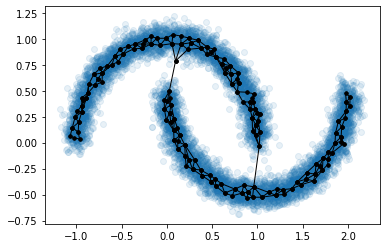

In [15]:
# BEST MODEL PLOT

fig = plt.figure()
plt.scatter(*input_data.T, alpha=0.1)
train_gng(best_model, input_data, "gifs/best_model_moons.gif")
Image(url='gifs/best_model_moons.gif')

/home/victorreno/anaconda3/envs/neural_networks/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/200 [00:00<?, ?it/s]

MovieWriter imagemagick unavailable; using Pillow instead.                     


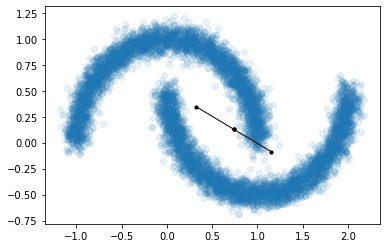

In [16]:
# Worst Model Plot

fig = plt.figure()
plt.scatter(*input_data.T, alpha=0.1)
train_gng(worst_model, input_data, "gifs/worst_model_moons.gif")
Image(url='gifs/worst_model_moons.gif')

## Conclusions

Using the 3 variable parameters (edge age, lambda and max nodes), it's possible to rank the best and worst models using a list ranking based on quantization error.

The best model succeeds in mapping the neurons on the examples presented to the network, slowly organizing themselfs arround the two moons, with almost no conections between them.

The worst model (with edge age of 1) can't even create a proper network, with it's neurons unstable and unable to map the exemples presented. Because of this, the network keeps creating and destroying the neurons.